In [1]:
from collections import OrderedDict
import copy
import torch.nn as nn
import torch.optim as optim
from itertools import product
from scipy.interpolate import griddata

from zephir.methods import *
from zephir.methods.build_pdists import get_all_pdists
from zephir.models.container import Container
from zephir.models.losses import corr_loss, reg_n
from zephir.utils.io import *
from zephir.utils.utils import *

from zephir.methods.recommend_frames import recommend_frames
from zephir.methods.extract_traces import extract_traces

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# path to dataset
dataset = Path('/Users/jimmie/Downloads/ZM9624')

In [3]:
dev = 'cpu'
with open(str(dataset / 'args.json')) as json_file:
    args = json.load(json_file)
args

{'--help': False,
 '--version': False,
 '--dataset': '.',
 '--dimmer_ratio': '0.1',
 '--n_epoch_d': '0',
 '--motion_predict': 'True',
 '--grid_shape': '49',
 '--fovea_sigma': '10.0',
 '--lr_coef': '2.0',
 '--t_track': None,
 '--allow_rotation': 'True',
 '--z_compensator': '4.0',
 '--n_epoch': '40',
 '--channel': '1',
 '--include_all': 'False',
 '--save_mode': 'w',
 '--gamma': '2',
 '--lambda_n_mode': 'norm',
 '--exclusive_prov': None,
 '--lr_floor': '0.01',
 '--load_checkpoint': 'False',
 '--lambda_t': '-1.0',
 '--load_args': 'True',
 '--wlid_ref': None,
 '--cuda': 'True',
 '--nn_max': '5',
 '--sort_mode': 'similarity',
 '--n_chunks': '1',
 '--lambda_n': '0.1',
 '--lambda_d': '0.1',
 '--clip_grad': '-1',
 '--n_frame': '1',
 '--t_ignore': None,
 '--t_ref': '498,444,463',
 '--load_nn': 'False',
 '--n_ref': None,
 '--lr_ceiling': '0.1',
 '--exclude_self': 'True'}

In [4]:
container = Container(
    dataset=dataset,
    allow_rotation=args['--allow_rotation'] in ['True', 'Y', 'y'],
    channel=int(args['--channel']) if args['--channel'] else None,
    dev=dev,
    exclude_self=args['--exclude_self'] in ['True', 'Y', 'y'],
    exclusive_prov=(bytes(args['--exclusive_prov'], 'utf-8')
                    if args['--exclusive_prov'] else None),
    gamma=float(args['--gamma']),
    include_all=args['--include_all'] in ['True', 'Y', 'y'],
    lr_coef=float(args['--lr_coef']),
    n_frame=int(args['--n_frame']),
    z_compensator=float(args['--z_compensator']),
)

container, results = build_annotations(
    container=container,
    annotation=None,
#     t_ref=eval(args['--t_ref']) if args['--t_ref'] else None,
    t_ref=None,
    wlid_ref=eval(args['--wlid_ref']) if args['--wlid_ref'] else None,
    n_ref=int(args['--n_ref']) if args['--n_ref'] else None,
)

container, zephir, zephod = build_models(
    container=container,
    dimmer_ratio=float(args['--dimmer_ratio']),
    grid_shape=(5, 2 * (int(args['--grid_shape']) // 2) + 1,
                2 * (int(args['--grid_shape']) // 2) + 1),
    fovea_sigma=(1, float(args['--fovea_sigma']),
                 float(args['--fovea_sigma'])),
    n_chunks=int(args['--n_chunks']),
)

container = build_springs(
    container=container,
    load_nn=args['--load_nn'] in ['True', 'Y', 'y'],
    nn_max=int(args['--nn_max']),
)

container = build_tree(
    container=container,
    sort_mode=str(args['--sort_mode']),
#     t_ignore=eval(args['--t_ignore']) if args['--t_ignore'] else None,
    t_ignore=None,
#     t_track=eval(args['--t_track']) if args['--t_track'] else None,
    t_track=None,
)

Checkpoint updated for ['container'] @ [2023-11-18 15:17:39.795082]
Using frame #0 as initial reference with 178 annotations found...

Annotations loaded for frames [0, 95, 98, 100, 149, 200, 271, 298, 389, 400, 444, 463, 498, 600, 640, 656, 672, 700, 764, 800, 806, 881, 900, 1000, 1038] with shape: (25, 178, 3)
*** Partial annotations found for 1035 frames
Checkpoint updated for ['container'] @ [2023-11-18 15:17:43.213774]
Checkpoint updated for ['results'] @ [2023-11-18 15:17:43.263718]

Compiling models and loss function...
*** CUDA NOT AVAILABLE! Mapping Zephod parameters to CPU...
Checkpoint updated for ['container'] @ [2023-11-18 15:17:43.356901]
Checkpoint updated for ['zephir_kwargs', 'zephir', 'zephod'] @ [2023-11-18 15:17:43.403685]

Building neighbor tree...
Checkpoint updated for ['container'] @ [2023-11-18 15:17:43.487975]

Building frame correlation graph...

Sorting frames by similarity to parent...

Frames sorted with max/mean distance	0.5786 / 0.0169
Checkpoint updated

In [5]:
img_shape = np.array(container.get('img_shape'))[::-1]
clip_grad=float(args['--clip_grad'])
lambda_t=float(args['--lambda_t'])
lambda_n=float(args['--lambda_n'])
lambda_n_mode=args['--lambda_n_mode']
lr_ceiling=float(args['--lr_ceiling'])
lr_floor=float(args['--lr_floor'])
n_epoch=int(args['--n_epoch'])
lr_coef = container.get('lr_coef')
s_list = container.get('s_list')
neighbors = container.get('neighbors')
covar = container.get('covar')
z_compensator = container.get('z_compensator')
nb_delta=(2, 1)
nb_epoch=5

# calculate initial learning rate based on parent-child distance
d_full = get_all_pdists(dataset, container.get('shape_t'), 1, pbar=True)

n_corr_ir = []
n_corr_ir_dl = []
n_corr_dl_c = []
n_corr_dl_i = []

In [6]:
n_corr_ir = []
root = 0
t_annot = container.get('t_annot')
for t_parent in tqdm(t_annot):
    
    a_parent = results[t_parent]
    v_parent = get_data(dataset, t_parent, c=1, g=2)
    with torch.no_grad():
        v_p = to_tensor(v_parent, n_dim=5, dev=dev)
        zephir.theta.zero_()
        zephir.rho.zero_()
        zephir.rho[:1].add_(
            to_tensor(a_parent, dev=dev).expand(1, -1, -1)
        )
        descriptors_p = zephir(v_p.expand(1, -1, -1, -1, -1, -1))

    if root >= len(t_annot):
        break
        
    for t_child in t_annot[root+1:]:
        
        a_child = results[t_child]
        v_child = get_data(dataset, t_child, c=1, g=2)

        with torch.no_grad():
            v_c = to_tensor(v_child, n_dim=5, dev=dev)
            zephir.theta.zero_()
            zephir.rho.zero_()
            zephir.rho[:1].add_(
                to_tensor(a_child, dev=dev).expand(1, -1, -1)
            )
            descriptors_c = zephir(v_c.expand(1, -1, -1, -1, -1, -1))

        pw_losses = np.zeros((descriptors_p.shape[1], descriptors_c.shape[1]))
        for i in range(descriptors_p.shape[1]):
            desc_p_i = descriptors_p[:, i, ...].unsqueeze(1)
            for j in range(descriptors_c.shape[1]):
                desc_c_j = descriptors_c[:, j, ...].unsqueeze(1)
                loss_ij = corr_loss(desc_c_j, desc_p_i)[0]
                pw_losses[i, j] = to_numpy(loss_ij)

        min_diff01 = np.empty((0, 2))
        min_corr = np.empty((0, 3))
        min_incorr = np.empty((0, 3))
        for i in range(pw_losses.shape[1]):
        #     plt.hist(pw_losses[i, :], bins='auto')
        #     plt.show()
            _sorted = np.sort(pw_losses[i, :])
            _min0, _min1 = _sorted[0], _sorted[1]
            min_diff01 = np.append(min_diff01, [[i, _min1 - _min0]], axis=0)
            if _min0 == pw_losses[i, i]:
                min_corr = np.append(min_corr, [[i, _min0, _min1]], axis=0)
            else:
                min_incorr = np.append(min_incorr, [[i, _min0, _min1]], axis=0)

        # print(f'Mean diff between min and next min: \n'
        #       f'\tCorrect ({len(min_corr)}): {np.mean(min_corr[:, 2] - min_corr[:, 1]):.5f} | {np.max(min_corr[:, 2] - min_corr[:, 1]):.5f}\n'
        #       f'\tIncorrect ({len(min_incorr)}): {np.mean(min_incorr[:, 2] - min_incorr[:, 1]):.5f} | {np.max(min_incorr[:, 2] - min_incorr[:, 1]):.5f}')
        # print(f'Thresholded at 0.05: \n'
        #       f'\tCorrect ({len(np.where((min_corr[:, 2] - min_corr[:, 1]) > 0.05)[0])}) \t|\t'
        #       f'\tIncorrect ({len(np.where((min_incorr[:, 2] - min_incorr[:, 1]) > 0.05)[0])})')
        n_corr_dl_c.append(len(np.where((min_corr[:, 2] - min_corr[:, 1]) > 0.05)[0]))
        n_corr_dl_i.append(len(np.where((min_incorr[:, 2] - min_incorr[:, 1]) > 0.05)[0]))

        # turn linked results to partial annotations here
        partial_annot = {}
        idx = min_diff01[np.where(min_diff01[:, 1] > 0.05)[0], 0].astype(int)
        partial_annot[t_child] = (idx, a_child[idx, :])

        distance = d_full[t_parent, t_child]
        if lr_coef > 0 and distance > 0:
            lr_init = min(max(lr_coef * distance, lr_floor), lr_ceiling)
        else:
            lr_init = lr_floor
        tqdm.write(f'\nFrame #{t_child}\t\tParent #{t_parent}'
                   f'\t\tDistance to parent: d={distance:.4f}')

        with torch.no_grad():

            # compiling target descriptors from reference frame for image registration, L_R
            zephir.theta.zero_()
            zephir.rho.zero_()
            zephir.rho[:1].add_(
                to_tensor(a_parent, dev=dev).expand(1, -1, -1)
            )
            target_tensor = zephir(v_p.expand(1, -1, -1, -1, -1, -1))

            # loading input volumes
            input_tensor = to_tensor(v_child, n_dim=5, dev=dev).expand(1, -1, -1, -1, -1, -1)

            # initializing model parameters at parent coordinates
            xyz_parent = to_tensor(a_parent, dev=dev)
            zephir.theta.zero_()
            zephir.rho.zero_()
            zephir.rho[:1].add_(
                xyz_parent.expand(1, -1, -1)
            )
            registration_init = to_numpy(zephir.rho)[0]

            # compiling spring connections and stiffnesses for spatial regularization, L_N
            ind = neighbors[root][:, :, 0]
            d_ref = to_tensor(neighbors[root][:, :, 1:], dev=dev)
            if covar is not None:
                nn_covar = np.empty_like(ind)
                for k in range(ind.shape[1]):
                    nn_covar[:, k] = covar[range(ind.shape[0]), ind[:, k].astype(int)]/20
                k_ij = to_tensor(
                    nn_covar /
                    np.clip(np.max(nn_covar, axis=-1)[:, None], 1, None),
                    grad=False, dev=dev
                )
                k_ij = lambda_n * torch.relu(k_ij)
            elif torch.max(d_ref) < 0:
                k_ij = torch.zeros_like(
                    to_tensor(ind), requires_grad=False, device=dev
                )
            else:
                k_ij = lambda_n * torch.ones_like(
                    to_tensor(ind), requires_grad=False, device=dev
                )

            # loading partial annotations if available
            p_idx, pins, params = [], [], []
            subset = _rho = None
            if t_child in partial_annot:
                _pins, _params = partial_annot[t_child]
                tqdm.write(f'*** Partial annotations available '
                           f'for {len(_pins)} keypoints')

                # using partial annotations to interpolate a flow field
                # and calculate new initial parameters for tracking
                corners = np.stack(list(product((-1, 1), repeat=3)), axis=0)
                p = np.append(results[t_parent, _pins, :], corners, axis=0)
                v = np.append(_params - results[t_parent, _pins, :], np.zeros((8, 3)), axis=0)
                gd = griddata(p, v, results[t_parent, ...], method='linear', fill_value=0)
                zephir.rho[0].add_(to_tensor(gd, dev=dev))

                # p_idx.append(0)
                # pins.append(to_tensor(_pins, dtype=torch.int64, dev=dev))
                # params.append(to_tensor(_params, dev=dev))

            # resetting optimizer state
            optimizer = optim.SGD(zephir.parameters(), lr=lr_init)
            scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.5)
            _kernel_size = (3, 9, 9)
            _sigmas = (1, 4, 4)

        # training loop here
        registration_results = np.zeros_like(a_child)
        zephir.train()
        pbar = tqdm(range(n_epoch), desc='Tracking', unit='epochs')
        for epoch in pbar:

            if (epoch + 1) % nb_epoch == 0:
                with torch.no_grad():
                    # updating kernels for dynamic Gaussian blurring
                    _kernel_size = (3, _kernel_size[1] - nb_delta[0], _kernel_size[2] - nb_delta[0])
                    _sigmas = (1, _sigmas[1] - nb_delta[1], _sigmas[1] - nb_delta[1])
                    if _kernel_size[1] <= 1 or _sigmas[1] <= 1:
                        # resets kernels to be inactive when it reaches a threshold
                        _kernel_size = (1, 1, 1)
                        _sigmas = (1, 1, 1)

            optimizer.zero_grad()

            # using automatic matrix precision casting to dynamically switch
            # between float16 and float32 to minimize memory consumption
            with torch.autocast(device_type=dev):

                # sampling child descriptors at model parameters from child frames
                pred = zephir(input_tensor)

                # dynamic Gaussian blurring
                blur_target = blur3d(target_tensor, _kernel_size, _sigmas, dev=dev)
                blur_pred = blur3d(pred, _kernel_size, _sigmas, dev=dev)

                reg = 0
                # image registration loss, L_R
                loss = torch.mean(corr_loss(blur_pred, blur_target))

                if torch.max(k_ij) > 0:
                    # spatial regularization, L_N
                    reg += torch.mean(
                        reg_n(k_ij, zephir.rho, _rho, ind, d_ref,
                              subset, lambda_n_mode)
                    )
                loss += reg

            # backpropagation call
            loss.backward()
            if clip_grad > 0.:
                nn.utils.clip_grad_value_(zephir.parameters(), clip_grad)
            if z_compensator > 0.:
                # due to anisotropy in depth-axis commonly found in 3D datasets,
                # gradient descent may not properly update parameters in that axis
                # so we multiply calculated gradients in that axis by (1+z_compensator)
                # to compensate
                with torch.no_grad():
                    zephir.rho[:, :, -1] += (
                        - z_compensator
                        * optimizer.param_groups[0]['lr']
                        * zephir.rho.grad[:, :, -1]
                    )

            # gradient descent step, update model parameters
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix(OrderedDict(
                    Loss=f'{loss.item():.4f}',
                    Loss_R=f'{(loss - reg).item():.4f}',
                    LR=f'{current_lr:.4f}'
                ))

                # resetting model parameters for rotation
                # if not allow_rotation:
                zephir.theta.zero_()

                for _i, i in enumerate(p_idx):
                    _pins, _params = pins[_i], params[_i]
                    if subset is not None:
                        _pins = [np.where(subset == w)[0][-1]
                                 for w in to_numpy(_pins) if w in subset]
                        _pins = to_tensor(_pins, dtype=torch.int64, dev=dev)
                    zephir.rho[i].index_fill_(0, _pins, 0)
                    zephir.rho[i].index_add_(0, _pins, _params)

        # updating array with tracking results for the child frame
        with torch.no_grad():
            registration_results = to_numpy(zephir.rho)[0]

        diff = a_child - registration_results
        diff = np.linalg.norm(diff / 2 * img_shape[None, :], axis=-1)
        n_corr = len(np.where(diff < 2.0)[0])
        # n_corr_ir.append(n_corr)
        n_corr_ir_dl.append(n_corr)
        
    root += 1

  0%|          | 0/25 [00:00<?, ?it/s]

Mean diff between min and next min: 
	Correct (69): 0.06649 | 0.15021
	Incorrect (109): 0.01994 | 0.11105
Thresholded at 0.05: 
	Correct (43) 	|		Incorrect (9)

Frame #95		Parent #0		Distance to parent: d=0.3244
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (82): 0.06791 | 0.16859
	Incorrect (96): 0.02600 | 0.12634
Thresholded at 0.05: 
	Correct (42) 	|		Incorrect (16)

Frame #98		Parent #0		Distance to parent: d=0.2947
*** Partial annotations available for 58 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (105): 0.07379 | 0.23147
	Incorrect (73): 0.02416 | 0.08943
Thresholded at 0.05: 
	Correct (70) 	|		Incorrect (11)

Frame #100		Parent #0		Distance to parent: d=0.1497
*** Partial annotations available for 81 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (131): 0.08759 | 0.23969
	Incorrect (47): 0.02962 | 0.13873
Thresholded at 0.05: 
	Correct (102) 	|		Incorrect (7)

Frame #149		Parent #0		Distance to parent: d=0.1019
*** Partial annotations available for 109 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (55): 0.03785 | 0.12460
	Incorrect (123): 0.02280 | 0.06816
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (14)

Frame #200		Parent #0		Distance to parent: d=0.4353
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (90): 0.04483 | 0.11425
	Incorrect (88): 0.02025 | 0.08525
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (12)

Frame #271		Parent #0		Distance to parent: d=0.2241
*** Partial annotations available for 50 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (37): 0.03849 | 0.10181
	Incorrect (141): 0.01839 | 0.10593
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (8)

Frame #298		Parent #0		Distance to parent: d=0.4106
*** Partial annotations available for 17 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (42): 0.04694 | 0.16483
	Incorrect (136): 0.01970 | 0.10622
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (10)

Frame #389		Parent #0		Distance to parent: d=0.5229
*** Partial annotations available for 27 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (40): 0.05200 | 0.12278
	Incorrect (138): 0.02000 | 0.11175
Thresholded at 0.05: 
	Correct (18) 	|		Incorrect (10)

Frame #400		Parent #0		Distance to parent: d=0.6668
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (132): 0.07519 | 0.24716
	Incorrect (46): 0.01960 | 0.06890
Thresholded at 0.05: 
	Correct (91) 	|		Incorrect (3)

Frame #444		Parent #0		Distance to parent: d=0.1857
*** Partial annotations available for 94 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (75): 0.05890 | 0.15648
	Incorrect (103): 0.02301 | 0.07853
Thresholded at 0.05: 
	Correct (42) 	|		Incorrect (10)

Frame #463		Parent #0		Distance to parent: d=0.3810
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (92): 0.07225 | 0.17980
	Incorrect (86): 0.01771 | 0.07233
Thresholded at 0.05: 
	Correct (63) 	|		Incorrect (4)

Frame #498		Parent #0		Distance to parent: d=0.3112
*** Partial annotations available for 67 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (87): 0.06399 | 0.18350
	Incorrect (91): 0.01989 | 0.07383
Thresholded at 0.05: 
	Correct (51) 	|		Incorrect (6)

Frame #600		Parent #0		Distance to parent: d=0.3218
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (76): 0.05625 | 0.16964
	Incorrect (102): 0.01925 | 0.08177
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (4)

Frame #640		Parent #0		Distance to parent: d=0.3111
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (48): 0.04043 | 0.13052
	Incorrect (130): 0.02391 | 0.09056
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (16)

Frame #656		Parent #0		Distance to parent: d=0.1772
*** Partial annotations available for 32 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (35): 0.02560 | 0.09106
	Incorrect (143): 0.01654 | 0.08856
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (6)

Frame #672		Parent #0		Distance to parent: d=0.4174
*** Partial annotations available for 11 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.03613 | 0.13237
	Incorrect (127): 0.01959 | 0.09077
Thresholded at 0.05: 
	Correct (15) 	|		Incorrect (10)

Frame #700		Parent #0		Distance to parent: d=0.1947
*** Partial annotations available for 25 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (34): 0.03083 | 0.10027
	Incorrect (144): 0.02384 | 0.07483
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (19)

Frame #764		Parent #0		Distance to parent: d=0.4663
*** Partial annotations available for 24 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (72): 0.03582 | 0.13983
	Incorrect (106): 0.02296 | 0.11615
Thresholded at 0.05: 
	Correct (24) 	|		Incorrect (11)

Frame #800		Parent #0		Distance to parent: d=0.2847
*** Partial annotations available for 35 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (66): 0.03885 | 0.15211
	Incorrect (112): 0.02161 | 0.08986
Thresholded at 0.05: 
	Correct (21) 	|		Incorrect (12)

Frame #806		Parent #0		Distance to parent: d=0.2208
*** Partial annotations available for 33 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (57): 0.04756 | 0.14803
	Incorrect (121): 0.01940 | 0.08099
Thresholded at 0.05: 
	Correct (22) 	|		Incorrect (9)

Frame #881		Parent #0		Distance to parent: d=0.3780
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (24): 0.04140 | 0.13166
	Incorrect (154): 0.02006 | 0.10734
Thresholded at 0.05: 
	Correct (7) 	|		Incorrect (7)

Frame #900		Parent #0		Distance to parent: d=0.4299
*** Partial annotations available for 14 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (42): 0.04152 | 0.12883
	Incorrect (136): 0.02258 | 0.13583
Thresholded at 0.05: 
	Correct (13) 	|		Incorrect (15)

Frame #1000		Parent #0		Distance to parent: d=0.3992
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (39): 0.03547 | 0.12200
	Incorrect (139): 0.01940 | 0.07769
Thresholded at 0.05: 
	Correct (11) 	|		Incorrect (11)

Frame #1038		Parent #0		Distance to parent: d=0.3935
*** Partial annotations available for 22 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (156): 0.11404 | 0.27590
	Incorrect (22): 0.02257 | 0.10918
Thresholded at 0.05: 
	Correct (133) 	|		Incorrect (2)

Frame #98		Parent #95		Distance to parent: d=0.0376
*** Partial annotations available for 135 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.07508 | 0.27342
	Incorrect (92): 0.02910 | 0.11873
Thresholded at 0.05: 
	Correct (55) 	|		Incorrect (17)

Frame #100		Parent #95		Distance to parent: d=0.1588
*** Partial annotations available for 72 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (68): 0.06412 | 0.19149
	Incorrect (110): 0.02647 | 0.11946
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (15)

Frame #149		Parent #95		Distance to parent: d=0.3160
*** Partial annotations available for 53 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (119): 0.07319 | 0.21674
	Incorrect (59): 0.01635 | 0.08195
Thresholded at 0.05: 
	Correct (78) 	|		Incorrect (4)

Frame #200		Parent #95		Distance to parent: d=0.0862
*** Partial annotations available for 82 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (30): 0.03294 | 0.09673
	Incorrect (148): 0.02085 | 0.12303
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (11)

Frame #271		Parent #95		Distance to parent: d=0.4000
*** Partial annotations available for 19 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (110): 0.07492 | 0.21495
	Incorrect (68): 0.02253 | 0.10569
Thresholded at 0.05: 
	Correct (71) 	|		Incorrect (8)

Frame #298		Parent #95		Distance to parent: d=0.1229
*** Partial annotations available for 79 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (21): 0.03100 | 0.11808
	Incorrect (157): 0.02272 | 0.12481
Thresholded at 0.05: 
	Correct (2) 	|		Incorrect (17)

Frame #389		Parent #95		Distance to parent: d=0.6651
*** Partial annotations available for 19 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (89): 0.07347 | 0.22665
	Incorrect (89): 0.03097 | 0.15065
Thresholded at 0.05: 
	Correct (53) 	|		Incorrect (17)

Frame #400		Parent #95		Distance to parent: d=0.4330
*** Partial annotations available for 70 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (48): 0.04345 | 0.14327
	Incorrect (130): 0.02206 | 0.10110
Thresholded at 0.05: 
	Correct (20) 	|		Incorrect (13)

Frame #444		Parent #95		Distance to parent: d=0.3615
*** Partial annotations available for 33 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (158): 0.10333 | 0.21650
	Incorrect (20): 0.01521 | 0.04714
Thresholded at 0.05: 
	Correct (136) 	|		Incorrect (0)

Frame #463		Parent #95		Distance to parent: d=0.0510
*** Partial annotations available for 136 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (95): 0.06065 | 0.17606
	Incorrect (83): 0.02275 | 0.11106
Thresholded at 0.05: 
	Correct (50) 	|		Incorrect (9)

Frame #498		Parent #95		Distance to parent: d=0.1328
*** Partial annotations available for 59 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (98): 0.05944 | 0.17921
	Incorrect (80): 0.02302 | 0.12062
Thresholded at 0.05: 
	Correct (54) 	|		Incorrect (9)

Frame #600		Parent #95		Distance to parent: d=0.1229
*** Partial annotations available for 63 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (85): 0.06548 | 0.19102
	Incorrect (93): 0.01983 | 0.07935
Thresholded at 0.05: 
	Correct (48) 	|		Incorrect (9)

Frame #640		Parent #95		Distance to parent: d=0.1774
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (32): 0.03138 | 0.15076
	Incorrect (146): 0.02441 | 0.12031
Thresholded at 0.05: 
	Correct (6) 	|		Incorrect (20)

Frame #656		Parent #95		Distance to parent: d=0.3195
*** Partial annotations available for 26 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (93): 0.06751 | 0.19548
	Incorrect (85): 0.02372 | 0.09283
Thresholded at 0.05: 
	Correct (54) 	|		Incorrect (8)

Frame #672		Parent #95		Distance to parent: d=0.1397
*** Partial annotations available for 62 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (27): 0.03071 | 0.11577
	Incorrect (151): 0.02181 | 0.12413
Thresholded at 0.05: 
	Correct (2) 	|		Incorrect (11)

Frame #700		Parent #95		Distance to parent: d=0.4236
*** Partial annotations available for 13 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (108): 0.06777 | 0.18385
	Incorrect (70): 0.02664 | 0.08084
Thresholded at 0.05: 
	Correct (65) 	|		Incorrect (12)

Frame #764		Parent #95		Distance to parent: d=0.1414
*** Partial annotations available for 77 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (53): 0.05151 | 0.13753
	Incorrect (125): 0.02225 | 0.12202
Thresholded at 0.05: 
	Correct (22) 	|		Incorrect (14)

Frame #800		Parent #95		Distance to parent: d=0.2228
*** Partial annotations available for 36 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (35): 0.03887 | 0.10752
	Incorrect (143): 0.02343 | 0.12464
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (20)

Frame #806		Parent #95		Distance to parent: d=0.3630
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (60): 0.05538 | 0.15921
	Incorrect (118): 0.02388 | 0.12040
Thresholded at 0.05: 
	Correct (26) 	|		Incorrect (14)

Frame #881		Parent #95		Distance to parent: d=0.1541
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (87): 0.06538 | 0.17054
	Incorrect (91): 0.02461 | 0.09974
Thresholded at 0.05: 
	Correct (56) 	|		Incorrect (8)

Frame #900		Parent #95		Distance to parent: d=0.1301
*** Partial annotations available for 64 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (67): 0.06519 | 0.16828
	Incorrect (111): 0.02456 | 0.10413
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (13)

Frame #1000		Parent #95		Distance to parent: d=0.1416
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (74): 0.06238 | 0.17726
	Incorrect (104): 0.02137 | 0.10130
Thresholded at 0.05: 
	Correct (41) 	|		Incorrect (11)

Frame #1038		Parent #95		Distance to parent: d=0.1313
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (96): 0.07579 | 0.21758
	Incorrect (82): 0.03121 | 0.12663
Thresholded at 0.05: 
	Correct (62) 	|		Incorrect (17)

Frame #100		Parent #98		Distance to parent: d=0.1104
*** Partial annotations available for 79 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (83): 0.06403 | 0.20212
	Incorrect (95): 0.02808 | 0.11921
Thresholded at 0.05: 
	Correct (47) 	|		Incorrect (14)

Frame #149		Parent #98		Distance to parent: d=0.2747
*** Partial annotations available for 61 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (99): 0.06155 | 0.17608
	Incorrect (79): 0.02155 | 0.07982
Thresholded at 0.05: 
	Correct (59) 	|		Incorrect (6)

Frame #200		Parent #98		Distance to parent: d=0.1418
*** Partial annotations available for 65 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (34): 0.03193 | 0.10333
	Incorrect (144): 0.02114 | 0.14900
Thresholded at 0.05: 
	Correct (7) 	|		Incorrect (13)

Frame #271		Parent #98		Distance to parent: d=0.3602
*** Partial annotations available for 20 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (95): 0.06494 | 0.21507
	Incorrect (83): 0.02322 | 0.12059
Thresholded at 0.05: 
	Correct (49) 	|		Incorrect (10)

Frame #298		Parent #98		Distance to parent: d=0.1632
*** Partial annotations available for 59 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (24): 0.02846 | 0.10784
	Incorrect (154): 0.02290 | 0.12877
Thresholded at 0.05: 
	Correct (2) 	|		Incorrect (15)

Frame #389		Parent #98		Distance to parent: d=0.6348
*** Partial annotations available for 17 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (77): 0.06997 | 0.20962
	Incorrect (101): 0.03132 | 0.15566
Thresholded at 0.05: 
	Correct (49) 	|		Incorrect (20)

Frame #400		Parent #98		Distance to parent: d=0.4368
*** Partial annotations available for 69 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (50): 0.04550 | 0.16776
	Incorrect (128): 0.02208 | 0.09865
Thresholded at 0.05: 
	Correct (19) 	|		Incorrect (11)

Frame #444		Parent #98		Distance to parent: d=0.3121
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (134): 0.07929 | 0.19014
	Incorrect (44): 0.02063 | 0.07196
Thresholded at 0.05: 
	Correct (91) 	|		Incorrect (3)

Frame #463		Parent #98		Distance to parent: d=0.0933
*** Partial annotations available for 94 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (89): 0.06008 | 0.14411
	Incorrect (89): 0.02565 | 0.11378
Thresholded at 0.05: 
	Correct (54) 	|		Incorrect (13)

Frame #498		Parent #98		Distance to parent: d=0.1239
*** Partial annotations available for 67 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (92): 0.05980 | 0.15188
	Incorrect (86): 0.02688 | 0.12885
Thresholded at 0.05: 
	Correct (49) 	|		Incorrect (13)

Frame #600		Parent #98		Distance to parent: d=0.1132
*** Partial annotations available for 62 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.05881 | 0.16527
	Incorrect (92): 0.02600 | 0.08426
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (10)

Frame #640		Parent #98		Distance to parent: d=0.1481
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (32): 0.03788 | 0.11253
	Incorrect (146): 0.02359 | 0.12056
Thresholded at 0.05: 
	Correct (6) 	|		Incorrect (16)

Frame #656		Parent #98		Distance to parent: d=0.3231
*** Partial annotations available for 22 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (79): 0.05440 | 0.14443
	Incorrect (99): 0.02449 | 0.12701
Thresholded at 0.05: 
	Correct (35) 	|		Incorrect (13)

Frame #672		Parent #98		Distance to parent: d=0.1924
*** Partial annotations available for 48 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (23): 0.03788 | 0.08413
	Incorrect (155): 0.02003 | 0.11546
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (13)

Frame #700		Parent #98		Distance to parent: d=0.4029
*** Partial annotations available for 18 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (84): 0.04645 | 0.12402
	Incorrect (94): 0.03024 | 0.15967
Thresholded at 0.05: 
	Correct (33) 	|		Incorrect (20)

Frame #764		Parent #98		Distance to parent: d=0.1954
*** Partial annotations available for 53 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (49): 0.03688 | 0.12444
	Incorrect (129): 0.02587 | 0.11554
Thresholded at 0.05: 
	Correct (14) 	|		Incorrect (23)

Frame #800		Parent #98		Distance to parent: d=0.2054
*** Partial annotations available for 37 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (32): 0.03549 | 0.10031
	Incorrect (146): 0.02395 | 0.10853
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (22)

Frame #806		Parent #98		Distance to parent: d=0.3470
*** Partial annotations available for 32 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (50): 0.04829 | 0.14530
	Incorrect (128): 0.02316 | 0.11374
Thresholded at 0.05: 
	Correct (25) 	|		Incorrect (14)

Frame #881		Parent #98		Distance to parent: d=0.1610
*** Partial annotations available for 39 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (70): 0.04538 | 0.12486
	Incorrect (108): 0.02865 | 0.13059
Thresholded at 0.05: 
	Correct (27) 	|		Incorrect (18)

Frame #900		Parent #98		Distance to parent: d=0.1748
*** Partial annotations available for 45 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (60): 0.05555 | 0.13685
	Incorrect (118): 0.02658 | 0.09240
Thresholded at 0.05: 
	Correct (28) 	|		Incorrect (18)

Frame #1000		Parent #98		Distance to parent: d=0.1563
*** Partial annotations available for 46 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (74): 0.04989 | 0.13302
	Incorrect (104): 0.02962 | 0.11920
Thresholded at 0.05: 
	Correct (35) 	|		Incorrect (18)

Frame #1038		Parent #98		Distance to parent: d=0.1625
*** Partial annotations available for 53 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (101): 0.08010 | 0.21555
	Incorrect (77): 0.02713 | 0.17270
Thresholded at 0.05: 
	Correct (69) 	|		Incorrect (11)

Frame #149		Parent #100		Distance to parent: d=0.1559
*** Partial annotations available for 80 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (57): 0.04023 | 0.10427
	Incorrect (121): 0.02343 | 0.10869
Thresholded at 0.05: 
	Correct (18) 	|		Incorrect (18)

Frame #200		Parent #100		Distance to parent: d=0.2550
*** Partial annotations available for 36 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (49): 0.04115 | 0.11374
	Incorrect (129): 0.01802 | 0.16812
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (6)

Frame #271		Parent #100		Distance to parent: d=0.2334
*** Partial annotations available for 23 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (53): 0.03906 | 0.13578
	Incorrect (125): 0.01961 | 0.11279
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (11)

Frame #298		Parent #100		Distance to parent: d=0.2612
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (27): 0.04273 | 0.12072
	Incorrect (151): 0.02370 | 0.13422
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (17)

Frame #389		Parent #100		Distance to parent: d=0.5786
*** Partial annotations available for 25 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (50): 0.05659 | 0.13488
	Incorrect (128): 0.02547 | 0.14485
Thresholded at 0.05: 
	Correct (23) 	|		Incorrect (13)

Frame #400		Parent #100		Distance to parent: d=0.5108
*** Partial annotations available for 36 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (84): 0.05291 | 0.19257
	Incorrect (94): 0.01968 | 0.14073
Thresholded at 0.05: 
	Correct (37) 	|		Incorrect (6)

Frame #444		Parent #100		Distance to parent: d=0.2029
*** Partial annotations available for 43 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.05591 | 0.14731
	Incorrect (92): 0.02453 | 0.14373
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (12)

Frame #463		Parent #100		Distance to parent: d=0.1874
*** Partial annotations available for 56 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (88): 0.05922 | 0.16773
	Incorrect (90): 0.02333 | 0.09659
Thresholded at 0.05: 
	Correct (48) 	|		Incorrect (11)

Frame #498		Parent #100		Distance to parent: d=0.1206
*** Partial annotations available for 59 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (87): 0.05685 | 0.18237
	Incorrect (91): 0.02741 | 0.11269
Thresholded at 0.05: 
	Correct (41) 	|		Incorrect (13)

Frame #600		Parent #100		Distance to parent: d=0.1266
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (84): 0.05454 | 0.19052
	Incorrect (94): 0.02557 | 0.10486
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (13)

Frame #640		Parent #100		Distance to parent: d=0.1146
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (36): 0.03799 | 0.15272
	Incorrect (142): 0.02387 | 0.11662
Thresholded at 0.05: 
	Correct (11) 	|		Incorrect (20)

Frame #656		Parent #100		Distance to parent: d=0.1971
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (47): 0.04361 | 0.11930
	Incorrect (131): 0.01852 | 0.07926
Thresholded at 0.05: 
	Correct (18) 	|		Incorrect (10)

Frame #672		Parent #100		Distance to parent: d=0.2776
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (38): 0.03431 | 0.11223
	Incorrect (140): 0.01894 | 0.07282
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (7)

Frame #700		Parent #100		Distance to parent: d=0.2560
*** Partial annotations available for 17 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (44): 0.04393 | 0.12759
	Incorrect (134): 0.02414 | 0.08448
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (15)

Frame #764		Parent #100		Distance to parent: d=0.2945
*** Partial annotations available for 32 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (67): 0.04268 | 0.13629
	Incorrect (111): 0.02606 | 0.10629
Thresholded at 0.05: 
	Correct (23) 	|		Incorrect (17)

Frame #800		Parent #100		Distance to parent: d=0.1423
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.03763 | 0.09723
	Incorrect (127): 0.02396 | 0.11643
Thresholded at 0.05: 
	Correct (14) 	|		Incorrect (15)

Frame #806		Parent #100		Distance to parent: d=0.2111
*** Partial annotations available for 29 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (49): 0.05732 | 0.14904
	Incorrect (129): 0.02210 | 0.11767
Thresholded at 0.05: 
	Correct (26) 	|		Incorrect (11)

Frame #881		Parent #100		Distance to parent: d=0.1814
*** Partial annotations available for 37 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (43): 0.04687 | 0.12904
	Incorrect (135): 0.02215 | 0.10630
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (16)

Frame #900		Parent #100		Distance to parent: d=0.2466
*** Partial annotations available for 33 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.05132 | 0.13954
	Incorrect (127): 0.02541 | 0.13223
Thresholded at 0.05: 
	Correct (22) 	|		Incorrect (19)

Frame #1000		Parent #100		Distance to parent: d=0.1933
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.04350 | 0.12076
	Incorrect (127): 0.02320 | 0.10299
Thresholded at 0.05: 
	Correct (19) 	|		Incorrect (17)

Frame #1038		Parent #100		Distance to parent: d=0.2082
*** Partial annotations available for 36 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (48): 0.05023 | 0.11327
	Incorrect (130): 0.02213 | 0.12885
Thresholded at 0.05: 
	Correct (23) 	|		Incorrect (12)

Frame #200		Parent #149		Distance to parent: d=0.4200
*** Partial annotations available for 35 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (103): 0.05740 | 0.22526
	Incorrect (75): 0.02398 | 0.18790
Thresholded at 0.05: 
	Correct (56) 	|		Incorrect (8)

Frame #271		Parent #149		Distance to parent: d=0.1838
*** Partial annotations available for 64 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (39): 0.03815 | 0.10043
	Incorrect (139): 0.01868 | 0.09990
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (9)

Frame #298		Parent #149		Distance to parent: d=0.4399
*** Partial annotations available for 18 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (35): 0.05110 | 0.16742
	Incorrect (143): 0.02026 | 0.13138
Thresholded at 0.05: 
	Correct (13) 	|		Incorrect (12)

Frame #389		Parent #149		Distance to parent: d=0.5406
*** Partial annotations available for 25 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (29): 0.04622 | 0.12001
	Incorrect (149): 0.02268 | 0.11702
Thresholded at 0.05: 
	Correct (12) 	|		Incorrect (11)

Frame #400		Parent #149		Distance to parent: d=0.6061
*** Partial annotations available for 23 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (155): 0.09946 | 0.28098
	Incorrect (23): 0.04468 | 0.25138
Thresholded at 0.05: 
	Correct (131) 	|		Incorrect (6)

Frame #444		Parent #149		Distance to parent: d=0.0416
*** Partial annotations available for 137 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (61): 0.05738 | 0.13726
	Incorrect (117): 0.02404 | 0.11664
Thresholded at 0.05: 
	Correct (29) 	|		Incorrect (14)

Frame #463		Parent #149		Distance to parent: d=0.3668
*** Partial annotations available for 43 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (81): 0.05700 | 0.14942
	Incorrect (97): 0.02437 | 0.08862
Thresholded at 0.05: 
	Correct (45) 	|		Incorrect (13)

Frame #498		Parent #149		Distance to parent: d=0.3064
*** Partial annotations available for 58 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (74): 0.05860 | 0.18026
	Incorrect (104): 0.02276 | 0.09478
Thresholded at 0.05: 
	Correct (41) 	|		Incorrect (11)

Frame #600		Parent #149		Distance to parent: d=0.3104
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (82): 0.06082 | 0.20751
	Incorrect (96): 0.02000 | 0.07039
Thresholded at 0.05: 
	Correct (37) 	|		Incorrect (11)

Frame #640		Parent #149		Distance to parent: d=0.2909
*** Partial annotations available for 48 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (69): 0.04912 | 0.19249
	Incorrect (109): 0.02512 | 0.13422
Thresholded at 0.05: 
	Correct (28) 	|		Incorrect (14)

Frame #656		Parent #149		Distance to parent: d=0.1388
*** Partial annotations available for 42 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (34): 0.03951 | 0.12508
	Incorrect (144): 0.02014 | 0.07581
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (8)

Frame #672		Parent #149		Distance to parent: d=0.4263
*** Partial annotations available for 17 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (89): 0.05179 | 0.16259
	Incorrect (89): 0.02119 | 0.10384
Thresholded at 0.05: 
	Correct (42) 	|		Incorrect (6)

Frame #700		Parent #149		Distance to parent: d=0.1207
*** Partial annotations available for 48 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (28): 0.04900 | 0.12855
	Incorrect (150): 0.02201 | 0.12117
Thresholded at 0.05: 
	Correct (15) 	|		Incorrect (15)

Frame #764		Parent #149		Distance to parent: d=0.4323
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (66): 0.05046 | 0.18236
	Incorrect (112): 0.02556 | 0.16018
Thresholded at 0.05: 
	Correct (29) 	|		Incorrect (18)

Frame #800		Parent #149		Distance to parent: d=0.2560
*** Partial annotations available for 47 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (92): 0.05712 | 0.17115
	Incorrect (86): 0.02301 | 0.17176
Thresholded at 0.05: 
	Correct (45) 	|		Incorrect (9)

Frame #806		Parent #149		Distance to parent: d=0.1326
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (45): 0.05455 | 0.17451
	Incorrect (133): 0.02370 | 0.10664
Thresholded at 0.05: 
	Correct (22) 	|		Incorrect (17)

Frame #881		Parent #149		Distance to parent: d=0.3611
*** Partial annotations available for 39 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (33): 0.04723 | 0.14262
	Incorrect (145): 0.02052 | 0.12223
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (12)

Frame #900		Parent #149		Distance to parent: d=0.4027
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (41): 0.05556 | 0.16937
	Incorrect (137): 0.02308 | 0.11152
Thresholded at 0.05: 
	Correct (24) 	|		Incorrect (15)

Frame #1000		Parent #149		Distance to parent: d=0.3735
*** Partial annotations available for 39 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (44): 0.04677 | 0.12818
	Incorrect (134): 0.02146 | 0.10296
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (13)

Frame #1038		Parent #149		Distance to parent: d=0.3772
*** Partial annotations available for 29 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (40): 0.04807 | 0.13582
	Incorrect (138): 0.02191 | 0.10697
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (13)

Frame #271		Parent #200		Distance to parent: d=0.4354
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (114): 0.08406 | 0.19126
	Incorrect (64): 0.02456 | 0.14610
Thresholded at 0.05: 
	Correct (87) 	|		Incorrect (10)

Frame #298		Parent #200		Distance to parent: d=0.0826
*** Partial annotations available for 97 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (16): 0.03820 | 0.11176
	Incorrect (162): 0.02514 | 0.11125
Thresholded at 0.05: 
	Correct (3) 	|		Incorrect (21)

Frame #389		Parent #200		Distance to parent: d=0.7036
*** Partial annotations available for 24 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (63): 0.06323 | 0.15618
	Incorrect (115): 0.02719 | 0.15554
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (15)

Frame #400		Parent #200		Distance to parent: d=0.4268
*** Partial annotations available for 53 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (36): 0.03371 | 0.08659
	Incorrect (142): 0.01999 | 0.09720
Thresholded at 0.05: 
	Correct (7) 	|		Incorrect (13)

Frame #444		Parent #200		Distance to parent: d=0.4350
*** Partial annotations available for 20 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (137): 0.08024 | 0.21120
	Incorrect (41): 0.02591 | 0.11843
Thresholded at 0.05: 
	Correct (100) 	|		Incorrect (6)

Frame #463		Parent #200		Distance to parent: d=0.0613
*** Partial annotations available for 106 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (94): 0.06578 | 0.19049
	Incorrect (84): 0.02189 | 0.09070
Thresholded at 0.05: 
	Correct (50) 	|		Incorrect (9)

Frame #498		Parent #200		Distance to parent: d=0.1958
*** Partial annotations available for 59 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (98): 0.06883 | 0.18530
	Incorrect (80): 0.02383 | 0.07817
Thresholded at 0.05: 
	Correct (58) 	|		Incorrect (11)

Frame #600		Parent #200		Distance to parent: d=0.1839
*** Partial annotations available for 69 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.06535 | 0.22451
	Incorrect (92): 0.02164 | 0.07797
Thresholded at 0.05: 
	Correct (46) 	|		Incorrect (6)

Frame #640		Parent #200		Distance to parent: d=0.2118
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (33): 0.04384 | 0.15224
	Incorrect (145): 0.02559 | 0.13554
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (20)

Frame #656		Parent #200		Distance to parent: d=0.4065
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (106): 0.07717 | 0.18277
	Incorrect (72): 0.02360 | 0.13429
Thresholded at 0.05: 
	Correct (76) 	|		Incorrect (9)

Frame #672		Parent #200		Distance to parent: d=0.1080
*** Partial annotations available for 85 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (35): 0.04247 | 0.11287
	Incorrect (143): 0.02288 | 0.12266
Thresholded at 0.05: 
	Correct (11) 	|		Incorrect (15)

Frame #700		Parent #200		Distance to parent: d=0.4886
*** Partial annotations available for 26 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (132): 0.07719 | 0.22192
	Incorrect (46): 0.03102 | 0.14806
Thresholded at 0.05: 
	Correct (97) 	|		Incorrect (8)

Frame #764		Parent #200		Distance to parent: d=0.0469
*** Partial annotations available for 105 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (61): 0.06167 | 0.19303
	Incorrect (117): 0.02533 | 0.17352
Thresholded at 0.05: 
	Correct (29) 	|		Incorrect (17)

Frame #800		Parent #200		Distance to parent: d=0.2641
*** Partial annotations available for 46 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (40): 0.04341 | 0.13760
	Incorrect (138): 0.02470 | 0.14384
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (17)

Frame #806		Parent #200		Distance to parent: d=0.4158
*** Partial annotations available for 34 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (64): 0.07798 | 0.20172
	Incorrect (114): 0.02396 | 0.14872
Thresholded at 0.05: 
	Correct (39) 	|		Incorrect (15)

Frame #881		Parent #200		Distance to parent: d=0.1611
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (107): 0.05773 | 0.20534
	Incorrect (71): 0.02352 | 0.11108
Thresholded at 0.05: 
	Correct (54) 	|		Incorrect (6)

Frame #900		Parent #200		Distance to parent: d=0.0856
*** Partial annotations available for 60 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (74): 0.06409 | 0.17598
	Incorrect (104): 0.02496 | 0.16854
Thresholded at 0.05: 
	Correct (41) 	|		Incorrect (10)

Frame #1000		Parent #200		Distance to parent: d=0.1254
*** Partial annotations available for 51 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (81): 0.05936 | 0.23941
	Incorrect (97): 0.02286 | 0.09902
Thresholded at 0.05: 
	Correct (41) 	|		Incorrect (9)

Frame #1038		Parent #200		Distance to parent: d=0.1325
*** Partial annotations available for 50 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (45): 0.05208 | 0.16299
	Incorrect (133): 0.01863 | 0.12451
Thresholded at 0.05: 
	Correct (21) 	|		Incorrect (9)

Frame #298		Parent #271		Distance to parent: d=0.4409
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (27): 0.04223 | 0.11929
	Incorrect (151): 0.02525 | 0.12026
Thresholded at 0.05: 
	Correct (11) 	|		Incorrect (23)

Frame #389		Parent #271		Distance to parent: d=0.5654
*** Partial annotations available for 34 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (29): 0.03925 | 0.17416
	Incorrect (149): 0.02556 | 0.14197
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (22)

Frame #400		Parent #271		Distance to parent: d=0.6048
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (96): 0.05410 | 0.21018
	Incorrect (82): 0.01999 | 0.08270
Thresholded at 0.05: 
	Correct (45) 	|		Incorrect (9)

Frame #444		Parent #271		Distance to parent: d=0.1662
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (40): 0.03876 | 0.10485
	Incorrect (138): 0.02088 | 0.08846
Thresholded at 0.05: 
	Correct (11) 	|		Incorrect (10)

Frame #463		Parent #271		Distance to parent: d=0.4003
*** Partial annotations available for 21 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (59): 0.04500 | 0.15645
	Incorrect (119): 0.02112 | 0.08142
Thresholded at 0.05: 
	Correct (24) 	|		Incorrect (9)

Frame #498		Parent #271		Distance to parent: d=0.2880
*** Partial annotations available for 33 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (54): 0.04717 | 0.14158
	Incorrect (124): 0.02145 | 0.07956
Thresholded at 0.05: 
	Correct (22) 	|		Incorrect (8)

Frame #600		Parent #271		Distance to parent: d=0.3081
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (62): 0.05473 | 0.14751
	Incorrect (116): 0.02302 | 0.09007
Thresholded at 0.05: 
	Correct (31) 	|		Incorrect (9)

Frame #640		Parent #271		Distance to parent: d=0.2859
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (71): 0.06090 | 0.17301
	Incorrect (107): 0.03024 | 0.17206
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (23)

Frame #656		Parent #271		Distance to parent: d=0.1578
*** Partial annotations available for 61 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (36): 0.05212 | 0.16375
	Incorrect (142): 0.02240 | 0.13525
Thresholded at 0.05: 
	Correct (13) 	|		Incorrect (17)

Frame #672		Parent #271		Distance to parent: d=0.4746
*** Partial annotations available for 30 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (88): 0.07355 | 0.18281
	Incorrect (90): 0.02642 | 0.09886
Thresholded at 0.05: 
	Correct (57) 	|		Incorrect (10)

Frame #700		Parent #271		Distance to parent: d=0.1251
*** Partial annotations available for 67 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (28): 0.05359 | 0.16846
	Incorrect (150): 0.02400 | 0.07964
Thresholded at 0.05: 
	Correct (14) 	|		Incorrect (21)

Frame #764		Parent #271		Distance to parent: d=0.4565
*** Partial annotations available for 35 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (64): 0.05921 | 0.23958
	Incorrect (114): 0.02500 | 0.11348
Thresholded at 0.05: 
	Correct (27) 	|		Incorrect (16)

Frame #800		Parent #271		Distance to parent: d=0.1960
*** Partial annotations available for 43 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (95): 0.07855 | 0.27203
	Incorrect (83): 0.02702 | 0.10504
Thresholded at 0.05: 
	Correct (61) 	|		Incorrect (14)

Frame #806		Parent #271		Distance to parent: d=0.0958
*** Partial annotations available for 75 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (49): 0.05583 | 0.17424
	Incorrect (129): 0.02018 | 0.10860
Thresholded at 0.05: 
	Correct (27) 	|		Incorrect (10)

Frame #881		Parent #271		Distance to parent: d=0.3549
*** Partial annotations available for 37 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (29): 0.04966 | 0.13889
	Incorrect (149): 0.02400 | 0.12566
Thresholded at 0.05: 
	Correct (14) 	|		Incorrect (19)

Frame #900		Parent #271		Distance to parent: d=0.4255
*** Partial annotations available for 33 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (45): 0.05228 | 0.14474
	Incorrect (133): 0.02531 | 0.22695
Thresholded at 0.05: 
	Correct (18) 	|		Incorrect (18)

Frame #1000		Parent #271		Distance to parent: d=0.3928
*** Partial annotations available for 36 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (42): 0.04823 | 0.17652
	Incorrect (136): 0.02470 | 0.11783
Thresholded at 0.05: 
	Correct (17) 	|		Incorrect (21)

Frame #1038		Parent #271		Distance to parent: d=0.4226
*** Partial annotations available for 38 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (17): 0.04430 | 0.16379
	Incorrect (161): 0.02448 | 0.12224
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (17)

Frame #389		Parent #298		Distance to parent: d=0.6953
*** Partial annotations available for 22 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (64): 0.06019 | 0.15877
	Incorrect (114): 0.02477 | 0.11823
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (14)

Frame #400		Parent #298		Distance to parent: d=0.4514
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (24): 0.02715 | 0.07802
	Incorrect (154): 0.02072 | 0.11559
Thresholded at 0.05: 
	Correct (1) 	|		Incorrect (12)

Frame #444		Parent #298		Distance to parent: d=0.4667
*** Partial annotations available for 13 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (109): 0.08407 | 0.21111
	Incorrect (69): 0.02307 | 0.12991
Thresholded at 0.05: 
	Correct (80) 	|		Incorrect (7)

Frame #463		Parent #298		Distance to parent: d=0.1028
*** Partial annotations available for 87 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.04704 | 0.13818
	Incorrect (92): 0.01953 | 0.09659
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (8)

Frame #498		Parent #298		Distance to parent: d=0.2138
*** Partial annotations available for 44 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (85): 0.05202 | 0.14739
	Incorrect (93): 0.02014 | 0.10130
Thresholded at 0.05: 
	Correct (42) 	|		Incorrect (7)

Frame #600		Parent #298		Distance to parent: d=0.2064
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (100): 0.05784 | 0.17128
	Incorrect (78): 0.02298 | 0.11525
Thresholded at 0.05: 
	Correct (53) 	|		Incorrect (8)

Frame #640		Parent #298		Distance to parent: d=0.2229
*** Partial annotations available for 61 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (28): 0.03284 | 0.10517
	Incorrect (150): 0.02515 | 0.14187
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (18)

Frame #656		Parent #298		Distance to parent: d=0.4255
*** Partial annotations available for 23 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (127): 0.11039 | 0.23527
	Incorrect (51): 0.02553 | 0.12088
Thresholded at 0.05: 
	Correct (103) 	|		Incorrect (5)

Frame #672		Parent #298		Distance to parent: d=0.0607
*** Partial annotations available for 108 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (29): 0.02997 | 0.10349
	Incorrect (149): 0.02319 | 0.16995
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (16)

Frame #700		Parent #298		Distance to parent: d=0.4921
*** Partial annotations available for 21 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (135): 0.09855 | 0.26568
	Incorrect (43): 0.03263 | 0.15549
Thresholded at 0.05: 
	Correct (103) 	|		Incorrect (7)

Frame #764		Parent #298		Distance to parent: d=0.0674
*** Partial annotations available for 110 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (66): 0.05634 | 0.17725
	Incorrect (112): 0.02547 | 0.12783
Thresholded at 0.05: 
	Correct (30) 	|		Incorrect (16)

Frame #800		Parent #298		Distance to parent: d=0.2686
*** Partial annotations available for 46 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (35): 0.03699 | 0.14398
	Incorrect (143): 0.02067 | 0.09080
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (14)

Frame #806		Parent #298		Distance to parent: d=0.4491
*** Partial annotations available for 23 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (75): 0.06169 | 0.17737
	Incorrect (103): 0.02442 | 0.09791
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (13)

Frame #881		Parent #298		Distance to parent: d=0.1125
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (122): 0.09044 | 0.20776
	Incorrect (56): 0.03063 | 0.15510
Thresholded at 0.05: 
	Correct (91) 	|		Incorrect (8)

Frame #900		Parent #298		Distance to parent: d=0.0560
*** Partial annotations available for 99 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (105): 0.07635 | 0.19195
	Incorrect (73): 0.03355 | 0.15637
Thresholded at 0.05: 
	Correct (70) 	|		Incorrect (18)

Frame #1000		Parent #298		Distance to parent: d=0.0921
*** Partial annotations available for 88 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (112): 0.07742 | 0.23515
	Incorrect (66): 0.03041 | 0.10200
Thresholded at 0.05: 
	Correct (71) 	|		Incorrect (14)

Frame #1038		Parent #298		Distance to parent: d=0.0848
*** Partial annotations available for 85 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (21): 0.04899 | 0.11939
	Incorrect (157): 0.02627 | 0.12067
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (24)

Frame #400		Parent #389		Distance to parent: d=0.6584
*** Partial annotations available for 34 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (40): 0.04189 | 0.12914
	Incorrect (138): 0.02108 | 0.11300
Thresholded at 0.05: 
	Correct (15) 	|		Incorrect (13)

Frame #444		Parent #389		Distance to parent: d=0.5345
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (27): 0.04169 | 0.13218
	Incorrect (151): 0.02316 | 0.14779
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (17)

Frame #463		Parent #389		Distance to parent: d=0.6532
*** Partial annotations available for 26 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (16): 0.03720 | 0.11556
	Incorrect (162): 0.02171 | 0.07974
Thresholded at 0.05: 
	Correct (4) 	|		Incorrect (12)

Frame #498		Parent #389		Distance to parent: d=0.6106
*** Partial annotations available for 16 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (14): 0.02680 | 0.06365
	Incorrect (164): 0.02232 | 0.08521
Thresholded at 0.05: 
	Correct (3) 	|		Incorrect (14)

Frame #600		Parent #389		Distance to parent: d=0.6276
*** Partial annotations available for 17 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (13): 0.03203 | 0.06624
	Incorrect (165): 0.02078 | 0.10350
Thresholded at 0.05: 
	Correct (2) 	|		Incorrect (13)

Frame #640		Parent #389		Distance to parent: d=0.6144
*** Partial annotations available for 15 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (25): 0.03920 | 0.12223
	Incorrect (153): 0.02223 | 0.08791
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (16)

Frame #656		Parent #389		Distance to parent: d=0.6144
*** Partial annotations available for 24 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (26): 0.03828 | 0.16063
	Incorrect (152): 0.02179 | 0.11161
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (15)

Frame #672		Parent #389		Distance to parent: d=0.7189
*** Partial annotations available for 24 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (18): 0.03735 | 0.09420
	Incorrect (160): 0.02128 | 0.11389
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (13)

Frame #700		Parent #389		Distance to parent: d=0.5636
*** Partial annotations available for 18 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (21): 0.05069 | 0.13692
	Incorrect (157): 0.02598 | 0.11321
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (18)

Frame #764		Parent #389		Distance to parent: d=0.7088
*** Partial annotations available for 27 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (23): 0.03174 | 0.11598
	Incorrect (155): 0.02581 | 0.11683
Thresholded at 0.05: 
	Correct (4) 	|		Incorrect (22)

Frame #800		Parent #389		Distance to parent: d=0.6277
*** Partial annotations available for 26 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (23): 0.04221 | 0.13874
	Incorrect (155): 0.02593 | 0.10432
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (24)

Frame #806		Parent #389		Distance to parent: d=0.5909
*** Partial annotations available for 33 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (19): 0.03894 | 0.14581
	Incorrect (159): 0.02574 | 0.15759
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (26)

Frame #881		Parent #389		Distance to parent: d=0.6464
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (21): 0.06887 | 0.15638
	Incorrect (157): 0.02834 | 0.16031
Thresholded at 0.05: 
	Correct (14) 	|		Incorrect (28)

Frame #900		Parent #389		Distance to parent: d=0.6812
*** Partial annotations available for 42 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (23): 0.04868 | 0.12999
	Incorrect (155): 0.02562 | 0.11649
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (19)

Frame #1000		Parent #389		Distance to parent: d=0.6582
*** Partial annotations available for 29 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (30): 0.04873 | 0.19699
	Incorrect (148): 0.02563 | 0.11568
Thresholded at 0.05: 
	Correct (13) 	|		Incorrect (22)

Frame #1038		Parent #389		Distance to parent: d=0.6781
*** Partial annotations available for 35 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (30): 0.03319 | 0.12460
	Incorrect (148): 0.02188 | 0.10700
Thresholded at 0.05: 
	Correct (6) 	|		Incorrect (16)

Frame #444		Parent #400		Distance to parent: d=0.5903
*** Partial annotations available for 22 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (97): 0.08416 | 0.25262
	Incorrect (81): 0.03038 | 0.15535
Thresholded at 0.05: 
	Correct (67) 	|		Incorrect (15)

Frame #463		Parent #400		Distance to parent: d=0.3930
*** Partial annotations available for 82 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (57): 0.06107 | 0.14643
	Incorrect (121): 0.02415 | 0.10314
Thresholded at 0.05: 
	Correct (29) 	|		Incorrect (12)

Frame #498		Parent #400		Distance to parent: d=0.4452
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (62): 0.05284 | 0.13446
	Incorrect (116): 0.02436 | 0.11534
Thresholded at 0.05: 
	Correct (29) 	|		Incorrect (12)

Frame #600		Parent #400		Distance to parent: d=0.4565
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (57): 0.06203 | 0.17729
	Incorrect (121): 0.02716 | 0.13013
Thresholded at 0.05: 
	Correct (31) 	|		Incorrect (16)

Frame #640		Parent #400		Distance to parent: d=0.4532
*** Partial annotations available for 47 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (24): 0.04233 | 0.16919
	Incorrect (154): 0.02349 | 0.13122
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (19)

Frame #656		Parent #400		Distance to parent: d=0.6030
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.05488 | 0.19578
	Incorrect (127): 0.02390 | 0.11697
Thresholded at 0.05: 
	Correct (20) 	|		Incorrect (20)

Frame #672		Parent #400		Distance to parent: d=0.4766
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (16): 0.04998 | 0.16183
	Incorrect (162): 0.01987 | 0.16647
Thresholded at 0.05: 
	Correct (5) 	|		Incorrect (13)

Frame #700		Parent #400		Distance to parent: d=0.6549
*** Partial annotations available for 18 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (68): 0.06639 | 0.18699
	Incorrect (110): 0.02623 | 0.10047
Thresholded at 0.05: 
	Correct (40) 	|		Incorrect (17)

Frame #764		Parent #400		Distance to parent: d=0.4414
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (47): 0.06350 | 0.18569
	Incorrect (131): 0.02751 | 0.13514
Thresholded at 0.05: 
	Correct (28) 	|		Incorrect (21)

Frame #800		Parent #400		Distance to parent: d=0.5004
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (28): 0.04164 | 0.19874
	Incorrect (150): 0.02404 | 0.12179
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (14)

Frame #806		Parent #400		Distance to parent: d=0.5890
*** Partial annotations available for 23 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (47): 0.06459 | 0.19592
	Incorrect (131): 0.02464 | 0.15205
Thresholded at 0.05: 
	Correct (23) 	|		Incorrect (17)

Frame #881		Parent #400		Distance to parent: d=0.4220
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (65): 0.06054 | 0.19639
	Incorrect (113): 0.02452 | 0.12370
Thresholded at 0.05: 
	Correct (33) 	|		Incorrect (16)

Frame #900		Parent #400		Distance to parent: d=0.4167
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (54): 0.07492 | 0.19054
	Incorrect (124): 0.02759 | 0.15722
Thresholded at 0.05: 
	Correct (31) 	|		Incorrect (18)

Frame #1000		Parent #400		Distance to parent: d=0.4106
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (47): 0.07352 | 0.21452
	Incorrect (131): 0.02682 | 0.17608
Thresholded at 0.05: 
	Correct (28) 	|		Incorrect (18)

Frame #1038		Parent #400		Distance to parent: d=0.4321
*** Partial annotations available for 46 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (64): 0.04464 | 0.14988
	Incorrect (114): 0.02318 | 0.10815
Thresholded at 0.05: 
	Correct (22) 	|		Incorrect (6)

Frame #463		Parent #444		Distance to parent: d=0.3918
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (85): 0.07102 | 0.16920
	Incorrect (93): 0.02346 | 0.07772
Thresholded at 0.05: 
	Correct (58) 	|		Incorrect (7)

Frame #498		Parent #444		Distance to parent: d=0.3276
*** Partial annotations available for 65 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (79): 0.06513 | 0.16453
	Incorrect (99): 0.02468 | 0.07632
Thresholded at 0.05: 
	Correct (51) 	|		Incorrect (8)

Frame #600		Parent #444		Distance to parent: d=0.3329
*** Partial annotations available for 59 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (73): 0.05182 | 0.14740
	Incorrect (105): 0.02009 | 0.08043
Thresholded at 0.05: 
	Correct (34) 	|		Incorrect (7)

Frame #640		Parent #444		Distance to parent: d=0.2995
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (72): 0.05609 | 0.21709
	Incorrect (106): 0.03230 | 0.10641
Thresholded at 0.05: 
	Correct (37) 	|		Incorrect (25)

Frame #656		Parent #444		Distance to parent: d=0.1462
*** Partial annotations available for 62 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (23): 0.03292 | 0.11853
	Incorrect (155): 0.02057 | 0.11836
Thresholded at 0.05: 
	Correct (4) 	|		Incorrect (12)

Frame #672		Parent #444		Distance to parent: d=0.4638
*** Partial annotations available for 16 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (113): 0.06924 | 0.24249
	Incorrect (65): 0.02155 | 0.12230
Thresholded at 0.05: 
	Correct (73) 	|		Incorrect (6)

Frame #700		Parent #444		Distance to parent: d=0.0901
*** Partial annotations available for 79 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (24): 0.03780 | 0.10515
	Incorrect (154): 0.02423 | 0.09341
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (18)

Frame #764		Parent #444		Distance to parent: d=0.4408
*** Partial annotations available for 26 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (65): 0.04995 | 0.16174
	Incorrect (113): 0.02632 | 0.09949
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (21)

Frame #800		Parent #444		Distance to parent: d=0.2598
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (120): 0.06534 | 0.26895
	Incorrect (58): 0.02312 | 0.09073
Thresholded at 0.05: 
	Correct (73) 	|		Incorrect (8)

Frame #806		Parent #444		Distance to parent: d=0.0995
*** Partial annotations available for 81 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (55): 0.05934 | 0.16405
	Incorrect (123): 0.02262 | 0.06990
Thresholded at 0.05: 
	Correct (33) 	|		Incorrect (11)

Frame #881		Parent #444		Distance to parent: d=0.3712
*** Partial annotations available for 44 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (26): 0.03212 | 0.08819
	Incorrect (152): 0.02511 | 0.11615
Thresholded at 0.05: 
	Correct (6) 	|		Incorrect (22)

Frame #900		Parent #444		Distance to parent: d=0.4153
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (39): 0.04322 | 0.15088
	Incorrect (139): 0.02190 | 0.11442
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (13)

Frame #1000		Parent #444		Distance to parent: d=0.3815
*** Partial annotations available for 29 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (32): 0.03805 | 0.12871
	Incorrect (146): 0.02534 | 0.09998
Thresholded at 0.05: 
	Correct (6) 	|		Incorrect (13)

Frame #1038		Parent #444		Distance to parent: d=0.3990
*** Partial annotations available for 19 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (124): 0.08656 | 0.27565
	Incorrect (54): 0.02993 | 0.09210
Thresholded at 0.05: 
	Correct (96) 	|		Incorrect (11)

Frame #498		Parent #463		Distance to parent: d=0.0909
*** Partial annotations available for 107 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (127): 0.08475 | 0.23710
	Incorrect (51): 0.02691 | 0.10273
Thresholded at 0.05: 
	Correct (91) 	|		Incorrect (7)

Frame #600		Parent #463		Distance to parent: d=0.0829
*** Partial annotations available for 98 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (111): 0.08415 | 0.21833
	Incorrect (67): 0.02506 | 0.10956
Thresholded at 0.05: 
	Correct (82) 	|		Incorrect (7)

Frame #640		Parent #463		Distance to parent: d=0.1254
*** Partial annotations available for 89 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (38): 0.04148 | 0.22954
	Incorrect (140): 0.02289 | 0.13809
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (15)

Frame #656		Parent #463		Distance to parent: d=0.3481
*** Partial annotations available for 25 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (111): 0.06881 | 0.18931
	Incorrect (67): 0.02197 | 0.13972
Thresholded at 0.05: 
	Correct (64) 	|		Incorrect (7)

Frame #672		Parent #463		Distance to parent: d=0.1248
*** Partial annotations available for 71 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (38): 0.03791 | 0.18233
	Incorrect (140): 0.02080 | 0.14705
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (8)

Frame #700		Parent #463		Distance to parent: d=0.4413
*** Partial annotations available for 16 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (133): 0.07839 | 0.16753
	Incorrect (45): 0.02465 | 0.14647
Thresholded at 0.05: 
	Correct (95) 	|		Incorrect (8)

Frame #764		Parent #463		Distance to parent: d=0.1096
*** Partial annotations available for 103 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (82): 0.06407 | 0.18539
	Incorrect (96): 0.02965 | 0.13089
Thresholded at 0.05: 
	Correct (49) 	|		Incorrect (15)

Frame #800		Parent #463		Distance to parent: d=0.2001
*** Partial annotations available for 64 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (49): 0.04566 | 0.15961
	Incorrect (129): 0.02448 | 0.15801
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (15)

Frame #806		Parent #463		Distance to parent: d=0.3645
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (76): 0.07547 | 0.20112
	Incorrect (102): 0.02742 | 0.14137
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (16)

Frame #881		Parent #463		Distance to parent: d=0.0909
*** Partial annotations available for 60 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (119): 0.06943 | 0.23875
	Incorrect (59): 0.02142 | 0.08654
Thresholded at 0.05: 
	Correct (76) 	|		Incorrect (7)

Frame #900		Parent #463		Distance to parent: d=0.0732
*** Partial annotations available for 83 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (87): 0.07784 | 0.20366
	Incorrect (91): 0.02262 | 0.07986
Thresholded at 0.05: 
	Correct (58) 	|		Incorrect (11)

Frame #1000		Parent #463		Distance to parent: d=0.0712
*** Partial annotations available for 69 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (94): 0.07096 | 0.20259
	Incorrect (84): 0.02364 | 0.10081
Thresholded at 0.05: 
	Correct (54) 	|		Incorrect (12)

Frame #1038		Parent #463		Distance to parent: d=0.0817
*** Partial annotations available for 66 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (171): 0.15473 | 0.34149
	Incorrect (7): 0.03153 | 0.05297
Thresholded at 0.05: 
	Correct (170) 	|		Incorrect (1)

Frame #600		Parent #498		Distance to parent: d=0.0054
*** Partial annotations available for 171 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (159): 0.10923 | 0.25082
	Incorrect (19): 0.02324 | 0.06781
Thresholded at 0.05: 
	Correct (139) 	|		Incorrect (4)

Frame #640		Parent #498		Distance to parent: d=0.0351
*** Partial annotations available for 143 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.06063 | 0.23841
	Incorrect (127): 0.02726 | 0.16399
Thresholded at 0.05: 
	Correct (27) 	|		Incorrect (20)

Frame #656		Parent #498		Distance to parent: d=0.2679
*** Partial annotations available for 47 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (72): 0.04758 | 0.13879
	Incorrect (106): 0.02004 | 0.11076
Thresholded at 0.05: 
	Correct (31) 	|		Incorrect (6)

Frame #672		Parent #498		Distance to parent: d=0.2473
*** Partial annotations available for 37 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (63): 0.05173 | 0.17698
	Incorrect (115): 0.02114 | 0.16218
Thresholded at 0.05: 
	Correct (28) 	|		Incorrect (9)

Frame #700		Parent #498		Distance to parent: d=0.3434
*** Partial annotations available for 37 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (81): 0.05015 | 0.14235
	Incorrect (97): 0.02030 | 0.09213
Thresholded at 0.05: 
	Correct (36) 	|		Incorrect (10)

Frame #764		Parent #498		Distance to parent: d=0.2504
*** Partial annotations available for 46 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (121): 0.08440 | 0.21131
	Incorrect (57): 0.03112 | 0.13526
Thresholded at 0.05: 
	Correct (93) 	|		Incorrect (13)

Frame #800		Parent #498		Distance to parent: d=0.0933
*** Partial annotations available for 106 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (75): 0.06196 | 0.16307
	Incorrect (103): 0.02138 | 0.08684
Thresholded at 0.05: 
	Correct (48) 	|		Incorrect (10)

Frame #806		Parent #498		Distance to parent: d=0.2622
*** Partial annotations available for 58 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (102): 0.08765 | 0.19714
	Incorrect (76): 0.02544 | 0.16278
Thresholded at 0.05: 
	Correct (72) 	|		Incorrect (10)

Frame #881		Parent #498		Distance to parent: d=0.0880
*** Partial annotations available for 82 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (69): 0.04511 | 0.17865
	Incorrect (109): 0.02579 | 0.09971
Thresholded at 0.05: 
	Correct (25) 	|		Incorrect (16)

Frame #900		Parent #498		Distance to parent: d=0.1875
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (90): 0.05549 | 0.17219
	Incorrect (88): 0.02549 | 0.08752
Thresholded at 0.05: 
	Correct (50) 	|		Incorrect (11)

Frame #1000		Parent #498		Distance to parent: d=0.1187
*** Partial annotations available for 61 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (80): 0.05256 | 0.17410
	Incorrect (98): 0.02448 | 0.09601
Thresholded at 0.05: 
	Correct (37) 	|		Incorrect (16)

Frame #1038		Parent #498		Distance to parent: d=0.1449
*** Partial annotations available for 53 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (159): 0.11760 | 0.25470
	Incorrect (19): 0.02271 | 0.06618
Thresholded at 0.05: 
	Correct (140) 	|		Incorrect (3)

Frame #640		Parent #600		Distance to parent: d=0.0343
*** Partial annotations available for 143 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (46): 0.06442 | 0.23701
	Incorrect (132): 0.02414 | 0.14298
Thresholded at 0.05: 
	Correct (24) 	|		Incorrect (20)

Frame #656		Parent #600		Distance to parent: d=0.2823
*** Partial annotations available for 44 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (79): 0.05001 | 0.16146
	Incorrect (99): 0.02126 | 0.12834
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (12)

Frame #672		Parent #600		Distance to parent: d=0.2361
*** Partial annotations available for 50 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (62): 0.05206 | 0.18880
	Incorrect (116): 0.02408 | 0.19694
Thresholded at 0.05: 
	Correct (26) 	|		Incorrect (14)

Frame #700		Parent #600		Distance to parent: d=0.3587
*** Partial annotations available for 40 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.05342 | 0.15964
	Incorrect (92): 0.02306 | 0.09674
Thresholded at 0.05: 
	Correct (40) 	|		Incorrect (14)

Frame #764		Parent #600		Distance to parent: d=0.2415
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (121): 0.08802 | 0.22941
	Incorrect (57): 0.03208 | 0.12400
Thresholded at 0.05: 
	Correct (88) 	|		Incorrect (14)

Frame #800		Parent #600		Distance to parent: d=0.1057
*** Partial annotations available for 102 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (77): 0.06415 | 0.17304
	Incorrect (101): 0.02269 | 0.08928
Thresholded at 0.05: 
	Correct (50) 	|		Incorrect (11)

Frame #806		Parent #600		Distance to parent: d=0.2795
*** Partial annotations available for 61 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (107): 0.09548 | 0.21671
	Incorrect (71): 0.02772 | 0.16127
Thresholded at 0.05: 
	Correct (83) 	|		Incorrect (11)

Frame #881		Parent #600		Distance to parent: d=0.0859
*** Partial annotations available for 94 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (77): 0.04599 | 0.13768
	Incorrect (101): 0.02603 | 0.09918
Thresholded at 0.05: 
	Correct (31) 	|		Incorrect (23)

Frame #900		Parent #600		Distance to parent: d=0.1819
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (91): 0.06102 | 0.16213
	Incorrect (87): 0.02755 | 0.12440
Thresholded at 0.05: 
	Correct (57) 	|		Incorrect (13)

Frame #1000		Parent #600		Distance to parent: d=0.1125
*** Partial annotations available for 70 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (86): 0.05475 | 0.16939
	Incorrect (92): 0.02551 | 0.09703
Thresholded at 0.05: 
	Correct (42) 	|		Incorrect (12)

Frame #1038		Parent #600		Distance to parent: d=0.1369
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (62): 0.05477 | 0.16019
	Incorrect (116): 0.02779 | 0.13461
Thresholded at 0.05: 
	Correct (31) 	|		Incorrect (21)

Frame #656		Parent #640		Distance to parent: d=0.2667
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (84): 0.06107 | 0.19466
	Incorrect (94): 0.01927 | 0.10700
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (8)

Frame #672		Parent #640		Distance to parent: d=0.2442
*** Partial annotations available for 52 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (65): 0.05282 | 0.15043
	Incorrect (113): 0.02140 | 0.16055
Thresholded at 0.05: 
	Correct (32) 	|		Incorrect (9)

Frame #700		Parent #640		Distance to parent: d=0.3385
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (87): 0.06011 | 0.15465
	Incorrect (91): 0.02442 | 0.10105
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (11)

Frame #764		Parent #640		Distance to parent: d=0.2360
*** Partial annotations available for 55 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (124): 0.10876 | 0.25701
	Incorrect (54): 0.03211 | 0.14172
Thresholded at 0.05: 
	Correct (110) 	|		Incorrect (11)

Frame #800		Parent #640		Distance to parent: d=0.0778
*** Partial annotations available for 121 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (81): 0.06505 | 0.19509
	Incorrect (97): 0.02203 | 0.09791
Thresholded at 0.05: 
	Correct (50) 	|		Incorrect (10)

Frame #806		Parent #640		Distance to parent: d=0.2564
*** Partial annotations available for 60 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (120): 0.08905 | 0.24240
	Incorrect (58): 0.02655 | 0.10919
Thresholded at 0.05: 
	Correct (89) 	|		Incorrect (6)

Frame #881		Parent #640		Distance to parent: d=0.0683
*** Partial annotations available for 95 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (94): 0.05887 | 0.19521
	Incorrect (84): 0.02462 | 0.07095
Thresholded at 0.05: 
	Correct (46) 	|		Incorrect (11)

Frame #900		Parent #640		Distance to parent: d=0.1768
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (109): 0.07553 | 0.18332
	Incorrect (69): 0.03127 | 0.12756
Thresholded at 0.05: 
	Correct (69) 	|		Incorrect (12)

Frame #1000		Parent #640		Distance to parent: d=0.0900
*** Partial annotations available for 81 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (108): 0.06580 | 0.17485
	Incorrect (70): 0.02674 | 0.12498
Thresholded at 0.05: 
	Correct (65) 	|		Incorrect (10)

Frame #1038		Parent #640		Distance to parent: d=0.1242
*** Partial annotations available for 75 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (31): 0.04718 | 0.11412
	Incorrect (147): 0.02259 | 0.09174
Thresholded at 0.05: 
	Correct (13) 	|		Incorrect (15)

Frame #672		Parent #656		Distance to parent: d=0.4158
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (105): 0.08324 | 0.33166
	Incorrect (73): 0.03364 | 0.16162
Thresholded at 0.05: 
	Correct (76) 	|		Incorrect (16)

Frame #700		Parent #656		Distance to parent: d=0.0827
*** Partial annotations available for 92 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (21): 0.04512 | 0.15750
	Incorrect (157): 0.02297 | 0.09261
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (19)

Frame #764		Parent #656		Distance to parent: d=0.4397
*** Partial annotations available for 28 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (65): 0.05524 | 0.24274
	Incorrect (113): 0.03190 | 0.17519
Thresholded at 0.05: 
	Correct (28) 	|		Incorrect (26)

Frame #800		Parent #656		Distance to parent: d=0.1846
*** Partial annotations available for 54 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (98): 0.08086 | 0.22759
	Incorrect (80): 0.03949 | 0.19799
Thresholded at 0.05: 
	Correct (66) 	|		Incorrect (26)

Frame #806		Parent #656		Distance to parent: d=0.0579
*** Partial annotations available for 92 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (49): 0.05435 | 0.18694
	Incorrect (129): 0.02738 | 0.18963
Thresholded at 0.05: 
	Correct (24) 	|		Incorrect (17)

Frame #881		Parent #656		Distance to parent: d=0.3543
*** Partial annotations available for 41 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (27): 0.03915 | 0.17059
	Incorrect (151): 0.02449 | 0.10658
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (14)

Frame #900		Parent #656		Distance to parent: d=0.4045
*** Partial annotations available for 22 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (29): 0.04803 | 0.19614
	Incorrect (149): 0.02236 | 0.10556
Thresholded at 0.05: 
	Correct (11) 	|		Incorrect (14)

Frame #1000		Parent #656		Distance to parent: d=0.3761
*** Partial annotations available for 25 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (37): 0.03172 | 0.11293
	Incorrect (141): 0.02167 | 0.09916
Thresholded at 0.05: 
	Correct (7) 	|		Incorrect (14)

Frame #1038		Parent #656		Distance to parent: d=0.3746
*** Partial annotations available for 21 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (30): 0.03726 | 0.10708
	Incorrect (148): 0.01977 | 0.19839
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (10)

Frame #700		Parent #672		Distance to parent: d=0.5010
*** Partial annotations available for 20 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (133): 0.12343 | 0.29710
	Incorrect (45): 0.04547 | 0.17522
Thresholded at 0.05: 
	Correct (110) 	|		Incorrect (15)

Frame #764		Parent #672		Distance to parent: d=0.0681
*** Partial annotations available for 125 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (59): 0.05459 | 0.14652
	Incorrect (119): 0.02630 | 0.14650
Thresholded at 0.05: 
	Correct (25) 	|		Incorrect (20)

Frame #800		Parent #672		Distance to parent: d=0.3108
*** Partial annotations available for 45 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (34): 0.04006 | 0.13457
	Incorrect (144): 0.02114 | 0.08878
Thresholded at 0.05: 
	Correct (12) 	|		Incorrect (12)

Frame #806		Parent #672		Distance to parent: d=0.4712
*** Partial annotations available for 24 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (70): 0.06605 | 0.19981
	Incorrect (108): 0.02557 | 0.10302
Thresholded at 0.05: 
	Correct (40) 	|		Incorrect (17)

Frame #881		Parent #672		Distance to parent: d=0.1359
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (115): 0.10015 | 0.23949
	Incorrect (63): 0.03823 | 0.18959
Thresholded at 0.05: 
	Correct (83) 	|		Incorrect (16)

Frame #900		Parent #672		Distance to parent: d=0.0628
*** Partial annotations available for 99 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (103): 0.07868 | 0.21627
	Incorrect (75): 0.02921 | 0.20714
Thresholded at 0.05: 
	Correct (68) 	|		Incorrect (9)

Frame #1000		Parent #672		Distance to parent: d=0.1055
*** Partial annotations available for 77 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (109): 0.09548 | 0.25999
	Incorrect (69): 0.03380 | 0.19258
Thresholded at 0.05: 
	Correct (84) 	|		Incorrect (18)

Frame #1038		Parent #672		Distance to parent: d=0.0637
*** Partial annotations available for 102 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (28): 0.04292 | 0.18451
	Incorrect (150): 0.02555 | 0.11649
Thresholded at 0.05: 
	Correct (8) 	|		Incorrect (23)

Frame #764		Parent #700		Distance to parent: d=0.5011
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (78): 0.05639 | 0.18501
	Incorrect (100): 0.02407 | 0.11570
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (15)

Frame #800		Parent #700		Distance to parent: d=0.2626
*** Partial annotations available for 53 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (131): 0.09473 | 0.29208
	Incorrect (47): 0.04342 | 0.14635
Thresholded at 0.05: 
	Correct (99) 	|		Incorrect (18)

Frame #806		Parent #700		Distance to parent: d=0.0542
*** Partial annotations available for 117 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (57): 0.05930 | 0.17773
	Incorrect (121): 0.02040 | 0.06683
Thresholded at 0.05: 
	Correct (25) 	|		Incorrect (11)

Frame #881		Parent #700		Distance to parent: d=0.4075
*** Partial annotations available for 36 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (26): 0.04188 | 0.14225
	Incorrect (152): 0.02233 | 0.10152
Thresholded at 0.05: 
	Correct (7) 	|		Incorrect (11)

Frame #900		Parent #700		Distance to parent: d=0.4703
*** Partial annotations available for 18 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (38): 0.04380 | 0.15282
	Incorrect (140): 0.02275 | 0.08754
Thresholded at 0.05: 
	Correct (13) 	|		Incorrect (14)

Frame #1000		Parent #700		Distance to parent: d=0.4390
*** Partial annotations available for 27 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (28): 0.04369 | 0.14403
	Incorrect (150): 0.02084 | 0.10582
Thresholded at 0.05: 
	Correct (9) 	|		Incorrect (10)

Frame #1038		Parent #700		Distance to parent: d=0.4515
*** Partial annotations available for 19 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (77): 0.05364 | 0.18603
	Incorrect (101): 0.02498 | 0.12512
Thresholded at 0.05: 
	Correct (33) 	|		Incorrect (12)

Frame #800		Parent #764		Distance to parent: d=0.2910
*** Partial annotations available for 45 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (33): 0.04417 | 0.14988
	Incorrect (145): 0.02225 | 0.12523
Thresholded at 0.05: 
	Correct (14) 	|		Incorrect (12)

Frame #806		Parent #764		Distance to parent: d=0.4445
*** Partial annotations available for 26 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (75): 0.05821 | 0.17922
	Incorrect (103): 0.02219 | 0.10729
Thresholded at 0.05: 
	Correct (38) 	|		Incorrect (11)

Frame #881		Parent #764		Distance to parent: d=0.1410
*** Partial annotations available for 49 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (131): 0.10492 | 0.28067
	Incorrect (47): 0.03396 | 0.13872
Thresholded at 0.05: 
	Correct (106) 	|		Incorrect (12)

Frame #900		Parent #764		Distance to parent: d=0.0447
*** Partial annotations available for 118 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (102): 0.07982 | 0.23931
	Incorrect (76): 0.02978 | 0.17216
Thresholded at 0.05: 
	Correct (63) 	|		Incorrect (12)

Frame #1000		Parent #764		Distance to parent: d=0.1044
*** Partial annotations available for 75 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (100): 0.08404 | 0.26740
	Incorrect (78): 0.02781 | 0.15550
Thresholded at 0.05: 
	Correct (70) 	|		Incorrect (15)

Frame #1038		Parent #764		Distance to parent: d=0.1009
*** Partial annotations available for 85 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (94): 0.06762 | 0.23011
	Incorrect (84): 0.03069 | 0.14118
Thresholded at 0.05: 
	Correct (53) 	|		Incorrect (16)

Frame #806		Parent #800		Distance to parent: d=0.1640
*** Partial annotations available for 69 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (101): 0.09873 | 0.22681
	Incorrect (77): 0.02665 | 0.16115
Thresholded at 0.05: 
	Correct (77) 	|		Incorrect (9)

Frame #881		Parent #800		Distance to parent: d=0.1455
*** Partial annotations available for 86 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (74): 0.06861 | 0.21993
	Incorrect (104): 0.02598 | 0.12417
Thresholded at 0.05: 
	Correct (45) 	|		Incorrect (17)

Frame #900		Parent #800		Distance to parent: d=0.2434
*** Partial annotations available for 62 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (88): 0.07631 | 0.20744
	Incorrect (90): 0.02714 | 0.10745
Thresholded at 0.05: 
	Correct (56) 	|		Incorrect (15)

Frame #1000		Parent #800		Distance to parent: d=0.1843
*** Partial annotations available for 71 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (71): 0.06787 | 0.17298
	Incorrect (107): 0.02524 | 0.13479
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (13)

Frame #1038		Parent #800		Distance to parent: d=0.2209
*** Partial annotations available for 57 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (75): 0.07178 | 0.20307
	Incorrect (103): 0.02676 | 0.13197
Thresholded at 0.05: 
	Correct (44) 	|		Incorrect (14)

Frame #881		Parent #806		Distance to parent: d=0.3434
*** Partial annotations available for 58 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (35): 0.04024 | 0.17143
	Incorrect (143): 0.02416 | 0.10895
Thresholded at 0.05: 
	Correct (10) 	|		Incorrect (22)

Frame #900		Parent #806		Distance to parent: d=0.4093
*** Partial annotations available for 32 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (51): 0.05595 | 0.16650
	Incorrect (127): 0.02211 | 0.11557
Thresholded at 0.05: 
	Correct (24) 	|		Incorrect (14)

Frame #1000		Parent #806		Distance to parent: d=0.3735
*** Partial annotations available for 38 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (47): 0.04303 | 0.13105
	Incorrect (131): 0.02153 | 0.11748
Thresholded at 0.05: 
	Correct (16) 	|		Incorrect (15)

Frame #1038		Parent #806		Distance to parent: d=0.4019
*** Partial annotations available for 31 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (87): 0.06061 | 0.17864
	Incorrect (91): 0.02674 | 0.12077
Thresholded at 0.05: 
	Correct (46) 	|		Incorrect (18)

Frame #900		Parent #881		Distance to parent: d=0.0678
*** Partial annotations available for 64 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (116): 0.09939 | 0.26732
	Incorrect (62): 0.02390 | 0.12240
Thresholded at 0.05: 
	Correct (92) 	|		Incorrect (5)

Frame #1000		Parent #881		Distance to parent: d=0.0192
*** Partial annotations available for 97 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (107): 0.08167 | 0.25193
	Incorrect (71): 0.02649 | 0.08878
Thresholded at 0.05: 
	Correct (69) 	|		Incorrect (12)

Frame #1038		Parent #881		Distance to parent: d=0.0395
*** Partial annotations available for 81 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (130): 0.09421 | 0.26455
	Incorrect (48): 0.04746 | 0.20529
Thresholded at 0.05: 
	Correct (93) 	|		Incorrect (12)

Frame #1000		Parent #900		Distance to parent: d=0.0336
*** Partial annotations available for 105 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (125): 0.10545 | 0.30475
	Incorrect (53): 0.05856 | 0.22022
Thresholded at 0.05: 
	Correct (97) 	|		Incorrect (20)

Frame #1038		Parent #900		Distance to parent: d=0.0329
*** Partial annotations available for 117 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

Mean diff between min and next min: 
	Correct (159): 0.14206 | 0.37786
	Incorrect (19): 0.01955 | 0.07785
Thresholded at 0.05: 
	Correct (147) 	|		Incorrect (2)

Frame #1038		Parent #1000		Distance to parent: d=0.0164
*** Partial annotations available for 149 keypoints


Tracking:   0%|          | 0/40 [00:00<?, ?epochs/s]

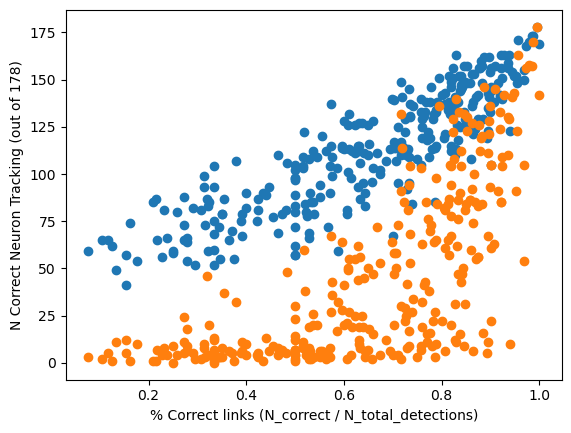

In [14]:
n_corr_ir = np.array(n_corr_ir)
n_corr_ir_dl = np.array(n_corr_ir_dl)
n_corr_dl_c = np.array(n_corr_dl_c)
n_corr_dl_i = np.array(n_corr_dl_i)
plt.scatter(n_corr_dl_c / (n_corr_dl_c + n_corr_dl_i), n_corr_ir_dl)
plt.scatter(n_corr_dl_c / (n_corr_dl_c + n_corr_dl_i), n_corr_ir)
plt.xlabel('% Correct links (N_correct / N_total_detections)')
plt.ylabel('N Correct Neuron Tracking (out of 178)')
plt.show()